# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures

# Set global random seed for numpy and sklearn for reproducibility.
np.random.seed(42)

# Functions

In [2]:
# Transform dates
def date_handler(date):
    return date - 1974

#Defining several evaluation functions for convenience
def wmape_calc(y, predictions):
    soma = 0

    for e, i in zip(y, predictions):
        if e < 1e-2:
            soma += abs(e-i)
        else:
            soma += abs(e - i) / abs(e)
    
    return soma

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions, sample_weight=y)
    wmape = wmape_calc(y, predictions)
    return mae, mse, rmse, r_squared, mape, wmape

# Load Data

In [3]:
data = pd.read_csv("permanent_database.csv", index_col=0)

# Verify that the data is loaded correctly
print(data.columns)

data.head()

Index(['year', 'city_code', 'product_type', 'product', 'destinated_area'], dtype='object')


,year,city_code,product_type,product,destinated_area
0,1974-01-01,960b4f2c94a2fb2c,permanent,Others,0.0
1,1974-01-01,746cc42bfb8f6b62,permanent,Others,0.0
2,1974-01-01,6cce2bf873870afc,permanent,Others,0.0
3,1974-01-01,4de42e351006a2ae,permanent,Others,0.0
4,1974-01-01,5b6072f8f6d37acc,permanent,Others,0.0


In [4]:
print(data.product_type.value_counts())
print('\n')
print(data['product'].value_counts())

permanent    25168
Name: product_type, dtype: int64


Others      6292
Cocoa       6292
Palm oil    6292
Açaí        6292
Name: product, dtype: int64


In [5]:
data.destinated_area.isna().sum()

16263

As we can see above there is a significant amount of NaN values in the destinated area field, the way we are going to treat this values is replacing them by 0, assuming that in the cities that don't exist this values is because there isn't the plantation there, e.g., area 0.

And the only numeric variable present in this dataset It's the destinated area, which is our target. But, we need to add more numeric variables in our dataset with the goal of predict the target.

The way we are going to do this is by encoding the year column in a sequencial way and getting the one hot encoding of the cities.

It will generate features that will feed our ML model to predict the desired years.

# Pre Processing Data

In [6]:
# convert year column to datetime
permanent_data = data.copy()

permanent_data['year'] = pd.to_datetime(permanent_data['year'], format='%Y-%m-%d')

permanent_data['ano'] = permanent_data['year'].apply(lambda x: x.year)

permanent_data['ano'] = permanent_data['ano'].apply(lambda x: date_handler(x))

# Fill NaN values with 0 in destinated_area column
permanent_data['destinated_area'] = permanent_data['destinated_area'].fillna(0)

permanent_data.sort_values(by='ano').head()

,year,city_code,product_type,product,destinated_area,ano
0,1974-01-01,960b4f2c94a2fb2c,permanent,Others,0.0,0
6292,1974-01-01,960b4f2c94a2fb2c,permanent,Cocoa,0.0,0
13924,1974-01-01,6cce2bf873870afc,permanent,Cocoa,0.0,0
13925,1974-01-01,5b6072f8f6d37acc,permanent,Palm oil,0.0,0
13926,1974-01-01,0307883b5d063703,permanent,Cocoa,0.0,0


In [7]:
# Convert cities column to categorical using pandas get_dummies (One Hot Encoding)
permanent_data = pd.get_dummies(permanent_data, columns=['city_code', 'product'])

permanent_data.head()

,year,product_type,destinated_area,ano,city_code_0307883b5d063703,city_code_03e477d4ede00e89,city_code_051e9cc7d7636816,city_code_062ce4c17e84291e,city_code_074590cfc1c41ebf,city_code_07bba1a59af78f2d,...,city_code_f4612b8b5a8223b5,city_code_f67358b81451a8d1,city_code_f8e70145d73bd728,city_code_fa005e1ffef6032a,city_code_fae378a53734da72,city_code_fda49275fbf5caf6,product_Açaí,product_Cocoa,product_Others,product_Palm oil
0,1974-01-01,permanent,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1974-01-01,permanent,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1974-01-01,permanent,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1974-01-01,permanent,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1974-01-01,permanent,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# X, y Split

In [8]:
# Splitting the data into X and y chunks
X = permanent_data.drop("destinated_area", axis=1)
y = permanent_data["destinated_area"]

# Standardizing the Data

In [9]:
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X.head()

,year,product_type,ano,city_code_0307883b5d063703,city_code_03e477d4ede00e89,city_code_051e9cc7d7636816,city_code_062ce4c17e84291e,city_code_074590cfc1c41ebf,city_code_07bba1a59af78f2d,city_code_07ce2e79e19977e9,...,city_code_f4612b8b5a8223b5,city_code_f67358b81451a8d1,city_code_f8e70145d73bd728,city_code_fa005e1ffef6032a,city_code_fae378a53734da72,city_code_fda49275fbf5caf6,product_Açaí,product_Cocoa,product_Others,product_Palm oil
0,1974-01-01,permanent,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1974-01-01,permanent,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1974-01-01,permanent,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1974-01-01,permanent,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1974-01-01,permanent,-1.693123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Train-Test Split

In [10]:
X_train = X[X['year'] < '2016-01-01']
X_test = X[X['year'] >= '2016-01-01']

y_train = y[X['year'] < '2016-01-01']
y_test = y[X['year'] >= '2016-01-01']

X_train = X_train.drop('year', axis=1)
X_train = X_train.drop(cat_cols, axis=1)
X_test = X_test.drop('year', axis=1)
X_test = X_test.drop(cat_cols, axis=1)

# Machine Learning Models

In [11]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","MAPE","WMAPE"])

# Linear Regression

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "LinearRegression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 1042.2647066571249
MSE: 10629526.721994264
RMSE: 3260.2954961159985
R2 Score: 0.08204200439505782
MAPE: 0.9418860638906619
WMAPE: 227663.06523397434
------------------------------


# Ridge Regression

In [13]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "Ridge","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 1042.8738330988558
MSE: 10634520.221039359
RMSE: 3261.061210869762
R2 Score: 0.0816107695438385
MAPE: 0.9422307820082011
WMAPE: 228013.8359892347
------------------------------


# Lasso Regression

In [14]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "Lasso","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 1068.7395854030806
MSE: 10765816.583129153
RMSE: 3281.13038191553
R2 Score: 0.07027211369147757
MAPE: 0.9566233968598836
WMAPE: 243250.65821061443
------------------------------


# Elastic Net

In [15]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
predictions = elastic_net.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "ElasticNet","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 1088.1665400221818
MSE: 11749937.479574945
RMSE: 3427.818180647122
R2 Score: -0.014715832541826623
MAPE: 0.9767270881472354
WMAPE: 243920.83522175468
------------------------------


# Support Vector Machines

In [22]:
svr = SVR(C=100000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "SVR","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

# Random Forest Regressor

In [16]:
random_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "RandomForestRegressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 384.4158916083916
MSE: 2531894.7388842655
RMSE: 1591.1928666520175
R2 Score: 0.7813474597340446
MAPE: 0.376410183099629
WMAPE: 52248.6409296028
------------------------------


# XGBoost Regressor

In [17]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "XGBRegressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 663.252255139651
MSE: 4109229.330290246
RMSE: 2027.1234126935256
R2 Score: 0.6451300214797739
MAPE: 0.5773190171141275
WMAPE: 168030.57753851643
------------------------------


# Polynomial Regression (Degree=2)

In [18]:
poly_reg = PolynomialFeatures(degree=2)
X_train_2d = poly_reg.fit_transform(X_train)
X_test_2d = poly_reg.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2d, y_train)
predictions = lin_reg.predict(X_test_2d)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "PolynomialFeatures","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MemoryError: Unable to allocate 2.00 GiB for an array with shape (24024, 11175) and data type float64

# Model Comparison

In [21]:
#The less the Root Mean Squared Error (R2), The better the model is.
models.sort_values(by="R2 Score")

,Model,MAE,MSE,RMSE,R2 Score,MAPE,WMAPE
3,ElasticNet,1088.166540,1.174994e+07,3427.818181,-0.014716,0.976727,243920.835222
2,Lasso,1068.739585,1.076582e+07,3281.130382,0.070272,0.956623,243250.658211
1,Ridge,1042.873833,1.063452e+07,3261.061211,0.081611,0.942231,228013.835989
0,LinearRegression,1042.264707,1.062953e+07,3260.295496,0.082042,0.941886,227663.065234
5,XGBRegressor,663.252255,4.109229e+06,2027.123413,0.645130,0.577319,168030.577539
4,RandomForestRegressor,384.415892,2.531895e+06,1591.192867,0.781347,0.376410,52248.640930


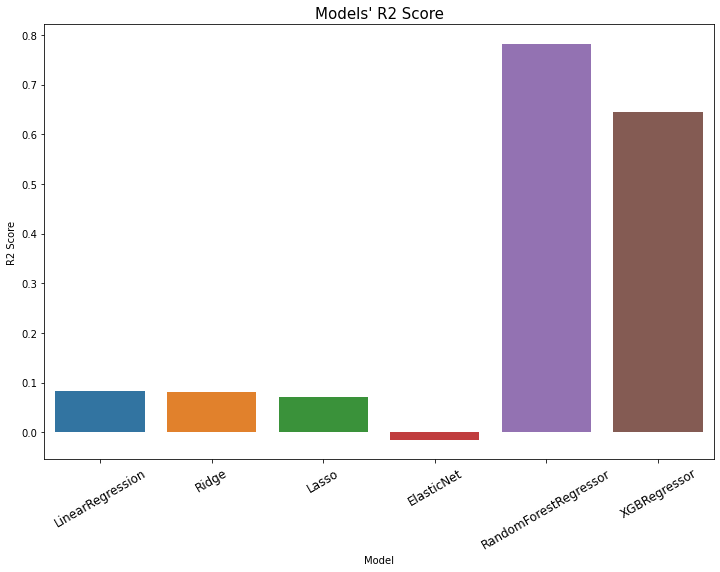

In [22]:
plt.figure(figsize=(12,8))
sns.barplot(x=models["Model"], y=models["R2 Score"])
plt.title("Models' R2 Score", size=15)
plt.xticks(rotation=30, size=12)
plt.show()